## LDA, LSI с Gensim и похожие по тематике тексты


In [9]:
import os
import re
from collections import defaultdict
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import lru_cache

from tqdm import tqdm

import gensim
import pymorphy3

In [10]:
dir(gensim.models)

['AtireBM25Model',
 'AuthorTopicModel',
 'BackMappingTranslationMatrix',
 'CoherenceModel',
 'Doc2Vec',
 'EnsembleLda',
 'FAST_VERSION',
 'FastText',
 'HdpModel',
 'KeyedVectors',
 'LdaModel',
 'LdaMulticore',
 'LdaSeqModel',
 'LogEntropyModel',
 'LsiModel',
 'LuceneBM25Model',
 'Nmf',
 'NormModel',
 'OkapiBM25Model',
 'Phrases',
 'RpModel',
 'TfidfModel',
 'TranslationMatrix',
 'VocabTransform',
 'Word2Vec',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_fasttext_bin',
 'atmodel',
 'basemodel',
 'bm25model',
 'callbacks',
 'coherencemodel',
 'doc2vec',
 'doc2vec_corpusfile',
 'doc2vec_inner',
 'ensemblelda',
 'fasttext',
 'fasttext_corpusfile',
 'fasttext_inner',
 'hdpmodel',
 'interfaces',
 'keyedvectors',
 'ldamodel',
 'ldamulticore',
 'ldaseqmodel',
 'logentropy_model',
 'lsimodel',
 'nmf',
 'nmf_pgd',
 'normmodel',
 'phrases',
 'rpmodel',
 'tfidfmodel',
 'translation_matrix',
 'utils',
 'word2vec',


In [11]:
morph = pymorphy3.MorphAnalyzer()

In [ ]:
# скачан датасет c https://tatianashavrina.github.io/taiga_site/news

In [58]:
dataset_folder = '../NPlus1/texts'

In [59]:
files = os.listdir(dataset_folder)

In [60]:
len(files)

7696

In [61]:
files[:10]

['20150928kc46a.txt',
 '20151001acoustic-diod.txt',
 '20150528planetary-fail.txt',
 '20160610reboot.txt',
 '20161011viknano.txt',
 '20161229Amazon-go-ahead.txt',
 '20170116all-resistant.txt',
 '20160425tunnelberyl.txt',
 '20160217china-gravitational-wave-projects.txt',
 '20150818superconducting-h2s.txt']

In [62]:
! du -sh ../NPlus1/texts

40M	../NPlus1/texts


In [64]:
with open(os.path.join(dataset_folder, files[1000]), 'r') as f:
    print(f.read())


Математики из Университета Северной Каролины обнаружили, что
распределение вещества внутри трубы зависит от формы ее сечения гораздо
сложнее, чем ранее предполагалось. Так, в круглых и эллиптических трубах концентрация гипотетического красителя, введенного в ток жидкости будет распределяться
симметрично, но, при переходе к квадратному сечению, эта симметрия исказится.
Авторы выяснили, что симметричным потоком, аналогичным у круглых труб, будут
обладать каналы прямоугольной формы с примерным соотношением ширины и высоты
два к одному. Исследование опубликовано в журнале Physical Review Letters, кратко о нем рассказывает журнал Physics.
Авторы работы проводили компьютерное моделирование того, как
будет меняться форма плоской прослойки красителя при движении по трубе. Из-за
того, что скорость потока в центре, например, круглой трубы, выше, чем  ее стенок, будет наблюдаться «выпучивание»
центральной части прослойки. Важным параметром, за которым следили
исследователи, была так называемая «

In [ ]:
# поднимем в память датасет

In [65]:
texts = []

for f in files:
    with open(os.path.join(dataset_folder, f), 'r') as fo:
        texts.append(fo.read())

In [11]:
print(texts[-2])


Группа китайских археологов подняла новые фрагменты останков бронепалубного крейсера «Чжиюань», затонувшего в 1894 году в Желтом море в ходе Японо-китайской войны. Об этом сообщает China News Service.Останки крейсера находятся в 59 километрах от устья реки Ялуцзян, неподалеку от городского округа Даньдун в провинции Ляонин. Всего со дна Желтого моря археологи подняли на поверхность останки тел семерых членов экипажа и около ста артефактов, включающих в себя детали орудийных установок крейсера, фрагменты обшивки и личные предметы матросов. 



In [67]:
def clear_text(t):
    t = str(t).lower()
    t = t.replace('\n', ' ')
    t = t.replace('.', '. ')
    t = t.replace(',', ', ')
    t = t.replace('xa0', ' ')
        
    return ' '.join(re.findall('[a-zа-яё]+', t))

In [68]:
texts_cleared = [clear_text(t) for t in texts]

In [69]:
texts_cleared[0]

'первый полностью укомплектованный всеми системами прототип перспективного американского самолета заправщика kc a pegasus совершил первый полет как сообщает defense news первый полет состоялся вечером сентября года на аэродроме концерна boeing в сиэтле в воздухе на самолете была проверена работа двигателей систем управления и систем создания искусственного климата в герметизированных отсеках общая продолжительность полета составила четыре часа в ближайшее время boeing занимающийся разработкой kc a намерен провести еще несколько испытательных полетов танкера в ходе которых он будет выпускать заправочную штангу и шланги будет проверяться влияние этих систем перекачки топлива на управляемость самолета затем данные предварительных испытаний прототипов будут переданы ввс сша а после этого транспортник будет участвовать в проверках на дозаправку других летательных аппаратов разработка kc a ведется на базе перспективного гражданского грузового самолета boeing c с года на танкер будут установл

In [70]:
text_lens = [len(t.split()) for t in texts]

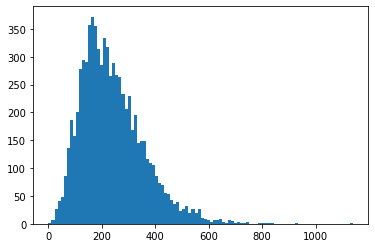

In [71]:
plt.hist(text_lens, bins=100)
plt.show()

In [74]:
texts_cleared[-1]

'на сайте nasa началась прямая трансляция шестичасового выхода в открытый космос членов экипажа мкс командир экипажа геннадий падалка и бортинженер михаил корниенко покинут шлюз в по московскому времени космонавты займутся инспекцией обшивки международной космической станции и монтажом вспомогательных мостков на обшивке станции для облегчения будущих выходов в космос также членам экипажа предстоит снять данные с оборудования установленного на мкс в рамках эксперимента обстановка произвести монтаж новой телекоммуникационной антенны и очистить от налета иллюминаторы служебного модуля звезда для бортинженера михаил корниенко это второй выход в открытый космос а для командира экипажа мкс уже десятый геннадий падалка провел в открытом космосе больше времени чем любой космонавт в истории'

In [75]:
texts_tokenized = [t.split() for t in texts_cleared]

In [76]:
texts_tokenized[-100]

['международная',
 'группа',
 'исследователей',
 'разработала',
 'метод',
 'аутентификации',
 'при',
 'помощи',
 'данных',
 'об',
 'использовании',
 'смартфона',
 'статья',
 'опубликована',
 'в',
 'acm',
 'digital',
 'library',
 'система',
 'получившая',
 'имя',
 'activpass',
 'анализирует',
 'на',
 'телефоне',
 'пользователя',
 'историю',
 'браузера',
 'посты',
 'на',
 'facebook',
 'и',
 'sms',
 'сообщения',
 'и',
 'использует',
 'полученные',
 'данные',
 'для',
 'того',
 'чтобы',
 'задавать',
 'вопросы',
 'при',
 'аутентификации',
 'на',
 'некоторых',
 'сервисах',
 'и',
 'сайтах',
 'например',
 'система',
 'может',
 'поинтересоваться',
 'кому',
 'первому',
 'сегодня',
 'отправлено',
 'sms',
 'с',
 'телефона',
 'всего',
 'для',
 'успешного',
 'логина',
 'нужно',
 'ответить',
 'на',
 'три',
 'вопроса',
 'связанных',
 'с',
 'недавними',
 'действиями',
 'пользователя',
 'в',
 'смартфоне',
 'когда',
 'вы',
 'что',
 'то',
 'делаете',
 'через',
 'свой',
 'смартфон',
 'это',
 'известно',
 'т

In [77]:
with open('stop_words.txt', 'r') as f:
    stop_words = f.read().split('\n')

In [78]:
stop_words_ = """или, но, дабы, затем, потом, лишь только, он, мы, его, вы, вам, вас, ее, что, 
который, их, все, они, я, весь, мне, меня, таким, для, на, по, со, из, от, до, без, над, под, за, при, после, во,
же, то, бы, всего, итого, даже, да, нет, ой, ого, эх, браво, здравствуйте, спасибо, извините,
скажем, может, допустим, честно говоря, например, на самом деле, однако, вообще, в, общем, вероятно, очень, 
минимально, максимально, абсолютно, огромный, предельно, сильно, слабо, самый, сайт, давать, всегда, однако, и, а, но, да, если, что, когда, потому, что, так, как, как, будто, 
вследствие, того, что, с, тех, пор, как, в, то, время, как, для, того, чтобы, ни, то, ли, но, зато, от, и, к, the"""

stop_words_1  = set(stop_words + stop_words_.replace('\n','').split(', '))

In [79]:
len(stop_words_1)

270

In [80]:
stop_words_1

{'',
 'the',
 'а',
 'абсолютно',
 'без',
 'более',
 'больше',
 'браво',
 'буд',
 'будет',
 'будто',
 'бы',
 'быв',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вами',
 'вас',
 'вдруг',
 'ведь',
 'вероятно',
 'весь',
 'во',
 'во,же',
 'вообще',
 'вот',
 'впрочем',
 'время',
 'все',
 'всегда',
 'всего',
 'всей',
 'всем',
 'всеми',
 'всему',
 'всех',
 'всею',
 'вследствие',
 'всю',
 'вся',
 'вы',
 'где',
 'говорил',
 'да',
 'дабы',
 'давать',
 'даже',
 'два',
 'дел',
 'для',
 'до',
 'долж',
 'допустим',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ею',
 'ж',
 'же',
 'жизнь',
 'за',
 'затем',
 'зато',
 'зачем',
 'здесь',
 'здравствуйте',
 'и',
 'из',
 'извините,скажем',
 'извинитескажем',
 'или',
 'им',
 'име',
 'ими',
 'иногда',
 'итого',
 'их',
 'к',
 'кажется',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'который',
 'кто',
 'куда',
 'ли',
 'лишь только',
 'лучше',
 'максимально',
 'между',
 'меня',
 'минимально',
 'мне',
 'много',
 'мной',
 

In [81]:
@lru_cache(100000)
def lemmatize(s):
    s = str(s).lower()
    return morph.parse(s)[0].normal_form

In [82]:
morph.parse('кошки')[0].normal_form

'кошка'

In [83]:
%%time

texts_tokenized_1 = [[lemmatize(tt) for tt in t if len(tt) > 1] 
                     for t in tqdm(texts_tokenized)]

100%|██████████████████████████████████████| 7696/7696 [00:35<00:00, 214.41it/s]

CPU times: user 35.2 s, sys: 391 ms, total: 35.6 s
Wall time: 35.9 s


In [84]:
texts_tokenized_1 = [[tt for tt in t if tt not in stop_words_1] 
                     for t in texts_tokenized_1]

In [85]:
texts_tokenized_1[-100]

['международный',
 'группа',
 'исследователь',
 'разработать',
 'метод',
 'аутентификация',
 'помощь',
 'данные',
 'использование',
 'смартфон',
 'статья',
 'опубликовать',
 'acm',
 'digital',
 'library',
 'система',
 'получить',
 'имя',
 'activpass',
 'анализировать',
 'телефон',
 'пользователь',
 'история',
 'браузер',
 'пост',
 'facebook',
 'sms',
 'сообщение',
 'использовать',
 'получить',
 'дать',
 'задавать',
 'вопрос',
 'аутентификация',
 'некоторый',
 'сервис',
 'система',
 'поинтересоваться',
 'первый',
 'отправить',
 'sms',
 'телефон',
 'успешный',
 'логин',
 'нужно',
 'ответить',
 'вопрос',
 'связанный',
 'недавний',
 'действие',
 'пользователь',
 'смартфон',
 'делать',
 'смартфон',
 'известно',
 'телефон',
 'именно',
 'поэтому',
 'дать',
 'использовать',
 'аутентификация',
 'объяснять',
 'рой',
 'чоудхурить',
 'соавтор',
 'исследование']

In [102]:
lemmatize('полученные')

'получить'

In [86]:
from gensim.models import Phrases
from gensim.corpora import Dictionary

In [88]:
docs = texts_tokenized_1

In [89]:
bigram = Phrases(docs, min_count=10)

In [90]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [93]:
docs[-100]

['международный',
 'группа',
 'исследователь',
 'разработать',
 'метод',
 'аутентификация',
 'помощь',
 'данные',
 'использование',
 'смартфон',
 'статья',
 'опубликовать',
 'acm',
 'digital',
 'library',
 'система',
 'получить',
 'имя',
 'activpass',
 'анализировать',
 'телефон',
 'пользователь',
 'история',
 'браузер',
 'пост',
 'facebook',
 'sms',
 'сообщение',
 'использовать',
 'получить',
 'дать',
 'задавать',
 'вопрос',
 'аутентификация',
 'некоторый',
 'сервис',
 'система',
 'поинтересоваться',
 'первый',
 'отправить',
 'sms',
 'телефон',
 'успешный',
 'логин',
 'нужно',
 'ответить',
 'вопрос',
 'связанный',
 'недавний',
 'действие',
 'пользователь',
 'смартфон',
 'делать',
 'смартфон',
 'известно',
 'телефон',
 'именно',
 'поэтому',
 'дать',
 'использовать',
 'аутентификация',
 'объяснять',
 'рой',
 'чоудхурить',
 'соавтор',
 'исследование',
 'международный_группа',
 'разработать_метод',
 'статья_опубликовать',
 'получить_имя',
 'получить_дать',
 'ответить_вопрос']

In [97]:
texts[-100]

'\nМеждународная группа исследователей разработала метод аутентификации при помощи данных об использовании смартфона.\nСтатья опубликована в ACM Digital Library.\nСистема,\nполучившая имя ActivPass, анализирует на\nтелефоне пользователя историю браузера,\nпосты на facebook и SMS-сообщения и использует\nполученные данные для того, чтобы\nзадавать вопросы при аутентификации\nна некоторых сервисах и сайтах. Например,\nсистема может поинтересоваться, кому\nпервому сегодня отправлено SMS с телефона.\nВсего для успешного логина нужно ответить\nна три вопроса, связанных с недавними\nдействиями пользователя в смартфоне.\n        «Когда вы что-то делаете через свой смартфон, это известно только вам и телефону, именно поэтому такие данные можно использовать для аутентификации»,— объясняет Рой Чоудхури, один из соавторов исследования.\n    \n'

In [98]:
dictionary = Dictionary(docs)

In [99]:
dictionary.filter_extremes(no_below=10, no_above=0.3)

In [106]:
# help(Dictionary)

In [104]:
vars(dictionary)

{'token2id': {'boeing': 0,
  'defense': 1,
  'kc': 2,
  'news': 3,
  'pegasus': 4,
  'август': 5,
  'август_год': 6,
  'американский': 7,
  'аппарат': 8,
  'аэродром': 9,
  'база': 10,
  'близкий': 11,
  'ввс': 12,
  'ввс_сша': 13,
  'вестись': 14,
  'вечером': 15,
  'влияние': 16,
  'воздух': 17,
  'впервые': 18,
  'выпускать': 19,
  'гражданский': 20,
  'график': 21,
  'грузовой': 22,
  'грузовой_самолёт': 23,
  'дать': 24,
  'двигатель': 25,
  'действовать': 26,
  'декабрь': 27,
  'декабрь_год': 28,
  'дозаправка': 29,
  'ещё': 30,
  'ещё_несколько': 31,
  'заниматься': 32,
  'заниматься_разработка': 33,
  'заправочный': 34,
  'заправочный_штанга': 35,
  'заправщик': 36,
  'искусственный': 37,
  'использование': 38,
  'испытание': 39,
  'испытание_прототип': 40,
  'испытательный': 41,
  'испытательный_полёт': 42,
  'июнь': 43,
  'июнь_год': 44,
  'кабина': 45,
  'кабина_пилот': 46,
  'километр': 47,
  'климат': 48,
  'конец': 49,
  'конец_год': 50,
  'концерн': 51,
  'концерн_boeing

In [108]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [109]:
corpus[10]

[(24, 2),
 (38, 1),
 (140, 1),
 (207, 3),
 (224, 1),
 (243, 1),
 (303, 1),
 (322, 1),
 (353, 2),
 (369, 1),
 (374, 1),
 (418, 1),
 (421, 1),
 (488, 1),
 (503, 1),
 (565, 1),
 (603, 2),
 (620, 1),
 (626, 1),
 (681, 1),
 (722, 1),
 (735, 1),
 (915, 1),
 (959, 2),
 (992, 1),
 (1014, 1),
 (1169, 1),
 (1173, 1),
 (1190, 1),
 (1205, 1),
 (1206, 1),
 (1207, 1),
 (1208, 1),
 (1209, 1),
 (1210, 1),
 (1211, 1),
 (1212, 1),
 (1213, 1),
 (1214, 1),
 (1215, 1),
 (1216, 1),
 (1217, 1),
 (1218, 1),
 (1219, 2),
 (1220, 1),
 (1221, 1),
 (1222, 1),
 (1223, 1),
 (1224, 1),
 (1225, 1),
 (1226, 1),
 (1227, 1),
 (1228, 1),
 (1229, 1),
 (1230, 1),
 (1231, 1),
 (1232, 1),
 (1233, 1),
 (1234, 1),
 (1235, 2),
 (1236, 1),
 (1237, 1),
 (1238, 1),
 (1239, 1),
 (1240, 1)]

In [110]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 12788
Number of documents: 7696


In [58]:
# dir(gensim.models)

In [111]:
# Train LDA model.
from gensim.models import LdaModel

In [45]:
help(LdaModel)

Help on class LdaModel in module gensim.models.ldamodel:

class LdaModel(gensim.interfaces.TransformationABC, gensim.models.basemodel.BaseTopicModel)
 |  LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>)
 |  
 |  Train and use Online Latent Dirichlet Allocation model as presented in
 |  `'Online Learning for LDA' by Hoffman et al.`_
 |  
 |  Examples
 |  -------
 |  Initialize a model using a Gensim corpus
 |  
 |  .. sourcecode:: pycon
 |  
 |      >>> from gensim.test.utils import common_corpus
 |      >>>
 |      >>> lda = LdaModel(common_corpus, num_topics=10)
 |  
 |  You can then infer topic distributions on new, unseen documents.
 |  
 |  .. sourcecode:: pycon
 | 

In [112]:
# Set training parameters.
num_topics = 20
chunksize = 4000
passes = 20
iterations = 400
eval_every = None 

In [113]:
%%time

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    workers=16
)

CPU times: user 1min 48s, sys: 8.03 s, total: 1min 56s
Wall time: 1min 59s


In [115]:
# dir(model)

In [116]:
topics = model.top_topics(corpus, topn=40)

In [143]:
topics[9]

([(0.009388572, 'животное'),
  (0.009366363, 'вид'),
  (0.008939142, 'группа'),
  (0.006167194, 'автор'),
  (0.0052563064, 'исследователь'),
  (0.004864744, 'самец'),
  (0.0044457125, 'самка'),
  (0.004400223, 'поведение'),
  (0.004369414, 'оказаться'),
  (0.004333529, 'птица'),
  (0.0039903056, 'показать'),
  (0.0037715235, 'журнал'),
  (0.0036913317, 'эксперимент'),
  (0.0035604218, 'процент'),
  (0.0033899765, 'статья'),
  (0.0033501445, 'рыба'),
  (0.0033367102, 'университет'),
  (0.0033168292, 'разный'),
  (0.0032850013, 'большой'),
  (0.0032712186, 'пища'),
  (0.0032168317, 'обнаружить'),
  (0.0031740027, 'друг'),
  (0.0031048711, 'случай'),
  (0.0030867446, 'результат'),
  (0.0030642047, 'собака'),
  (0.0028918143, 'растение'),
  (0.0028632795, 'особь'),
  (0.0027550326, 'шимпанзе'),
  (0.0027445056, 'of'),
  (0.0027265442, 'всё'),
  (0.0025962626, 'количество'),
  (0.0025851778, 'некоторый'),
  (0.0025117865, 'звук'),
  (0.0024331536, 'несколько'),
  (0.0023590983, 'насекомое')

In [141]:
vector = model[corpus[300]]

vector

[(2, 0.45042276), (4, 0.010448395), (5, 0.21714069), (9, 0.31626222)]

In [128]:
sum([t[1] for t in vector])

0.9953092932701111

In [136]:
print(texts[300])


Первый аппарат миссии «Экзомарс» успешно стартовал с российского космодрома Байконур. Ракета-носитель «Протон-М» отработала штатно, произошло отделение первой и второй ступени, а также головного обтекателя. Первый сигнал ожидается 15 марта в 00:29 по московскому времени. Запуск транслировался в прямом эфире.На первом этапе полета — первые шесть недель — зонд будет вводиться в эксплуатацию, будут проводиться тесты оборудования. Затем в июле модуль Trace Gas Orbiter скорректирует свою траекторию. Аппарат достигнет красной планеты примерно 19 октября.По достижении орбиты планеты аппарат освободит крепления спускаемого модуля «Скиапарелли» и выйдет на орбиту высотой несколько сотен километров. Главная задача Trace Gas Orbiter — спектроскопический анализ атмосферы и поиск в ней следов метана. Задача же «Скиапарелли» — отработка технологии посадки. На поверхности планеты он проработает всего несколько дней, впервые сделав замеры электрических полей, чтобы определить их роль в пылевых бурях.

In [82]:
topics[19]

([(0.012502011, 'компьютер'),
  (0.009208937, 'raspberry_pi'),
  (0.008691674, 'квантовый_компьютер'),
  (0.008122121, 'cas'),
  (0.007926604, 'crispr'),
  (0.0077464515, 'crispr_cas'),
  (0.0062066875, 'система_crispr'),
  (0.0056438358, 'геном'),
  (0.0053471248, 'pi'),
  (0.005282883, 'технология'),
  (0.0052618147, 'редактирование_геном'),
  (0.0050939517, 'процессор'),
  (0.004581097, 'квантовый'),
  (0.0041720015, 'raspberry'),
  (0.0039178357, 'компания'),
  (0.0038469962, 'память'),
  (0.003811892, 'рнк'),
  (0.0037756753, 'вич'),
  (0.0035278471, 'технология_crispr'),
  (0.0033364177, 'позволять'),
  (0.003318232, 'операционный_система'),
  (0.0032609154, 'редактирование'),
  (0.0032008851, 'закрылок'),
  (0.0029810097, 'гигабайт'),
  (0.0027460563, 'сша'),
  (0.0026905527, 'гигабайт_оперативный'),
  (0.0025756522, 'кубит'),
  (0.0025112345, 'вычислительный'),
  (0.0025065271, 'днк'),
  (0.0024225686, 'оперативный_память'),
  (0.0024026486, 'несколько'),
  (0.0023924743, 'рабо

In [53]:
model.save('LDA_model.gensim')

In [54]:
# model.add_documents

### LSI Model

In [144]:
%%time

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model_lsi = gensim.models.LsiModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20,
)

CPU times: user 9.11 s, sys: 17.8 s, total: 26.9 s
Wall time: 6.8 s


In [85]:
help(gensim.models.LsiModel)

Help on class LsiModel in module gensim.models.lsimodel:

class LsiModel(gensim.interfaces.TransformationABC, gensim.models.basemodel.BaseTopicModel)
 |  LsiModel(corpus=None, num_topics=200, id2word=None, chunksize=20000, decay=1.0, distributed=False, onepass=True, power_iters=2, extra_samples=100, dtype=<class 'numpy.float64'>)
 |  
 |  Model for `Latent Semantic Indexing
 |  <https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing>`_.
 |  
 |  The decomposition algorithm is described in `"Fast and Faster: A Comparison of Two Streamed
 |  Matrix Decomposition Algorithms" <https://nlp.fi.muni.cz/~xrehurek/nips/rehurek_nips.pdf>`_.
 |  
 |  Notes
 |  -----
 |  * :attr:`gensim.models.lsimodel.LsiModel.projection.u` - left singular vectors,
 |  * :attr:`gensim.models.lsimodel.LsiModel.projection.s` - singular values,
 |  * ``model[training_corpus]`` - right singular vectors (can be reconstructed if needed).
 |  
 |  See Also
 |  --------
 |  `FAQ about LSI matrice

In [86]:
[m for m in dir(model) if not m.startswith('_')]

['alpha',
 'batch',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offset',
 'optimize_alpha',
 'optimize_eta',
 'passes',
 'per_word_topics',
 'print_topic',
 'print_topics',
 'random_state',
 'save',
 'show_topic',
 'show_topics',
 'state',
 'sync_state',
 'top_topics',
 'update',
 'update_alpha',
 'update_eta',
 'update_every',
 'workers']

In [87]:
help(model_lsi.add_documents)

Help on method add_documents in module gensim.models.lsimodel:

add_documents(corpus, chunksize=None, decay=None) method of gensim.models.lsimodel.LsiModel instance
    Update model with new `corpus`.
    
    Parameters
    ----------
    corpus : {iterable of list of (int, float), scipy.sparse.csc}
        Stream of document vectors or sparse matrix of shape (`num_terms`, num_documents).
    chunksize : int, optional
        Number of documents to be used in each training chunk, will use `self.chunksize` if not specified.
    decay : float, optional
        Weight of existing observations relatively to new ones,  will use `self.decay` if not specified.
    
    Notes
    -----
    Training proceeds in chunks of `chunksize` documents at a time. The size of `chunksize` is a tradeoff
    between increased speed (bigger `chunksize`) vs. lower memory footprint (smaller `chunksize`).
    If the distributed mode is on, each chunk is sent to a different worker/computer.



In [145]:
topics1 = model_lsi.get_topics()

In [146]:
topics1

array([[ 1.68650808e-02,  1.25862335e-02,  4.87870830e-03, ...,
         4.02892851e-04,  5.31587719e-04,  4.96644920e-04],
       [ 2.99290174e-02,  1.91296458e-02,  1.05392380e-02, ...,
        -3.87849303e-04, -4.00906358e-04, -6.45753268e-04],
       [ 3.54510533e-02,  5.53638621e-03,  1.78147634e-02, ...,
         5.55159598e-05, -1.39707922e-04,  1.11080362e-04],
       ...,
       [ 8.42724001e-03,  5.18216592e-03,  2.42144458e-03, ...,
         3.58649287e-04,  4.01418690e-04, -7.48857402e-04],
       [-1.40325773e-02,  6.02196192e-03, -2.67136029e-03, ...,
         1.64826331e-04, -2.83109574e-04, -5.91737674e-04],
       [ 1.16645596e-02,  1.90442405e-03, -2.26524293e-04, ...,
         5.17272293e-05,  8.80020450e-04, -6.87188997e-05]])

In [147]:
topics1[0].shape

(12788,)

In [173]:
model_lsi.print_topics(-1, num_words=40)[2]

(2,
 '0.468*"самолёт" + 0.299*"клетка" + -0.202*"робот" + -0.201*"аппарат" + 0.144*"ген" + -0.141*"звезда" + 0.136*"мозг" + -0.128*"автомобиль" + -0.123*"планета" + -0.115*"беспилотник" + -0.112*"объект" + 0.111*"истребитель" + -0.104*"компания" + -0.102*"беспилотный" + 0.098*"мышь" + -0.093*"космический" + 0.089*"белок" + -0.085*"устройство" + 0.084*"днк" + 0.080*"животное" + 0.078*"нейрон" + -0.076*"орбита" + -0.073*"земля" + -0.072*"галактика" + 0.067*"группа" + 0.066*"двигатель" + 0.066*"активность" + 0.066*"геном" + -0.065*"спутник" + -0.064*"находиться" + 0.064*"полёт" + -0.063*"частица" + -0.063*"камера" + -0.062*"поверхность" + 0.060*"показать" + 0.059*"ткань" + -0.058*"излучение" + 0.058*"ввс" + 0.058*"сша" + 0.055*"развитие"')

In [156]:
vector = model_lsi[corpus[300]]

vector

[(0, 3.039716392680883),
 (1, 0.8971408183669063),
 (2, -2.540951192683333),
 (3, 1.982005902748673),
 (4, -3.2233513933334463),
 (5, -0.05916108215865734),
 (6, -0.06217426374018147),
 (7, 0.5317891191619057),
 (8, -0.1822024307659729),
 (9, -1.1745455790207964),
 (10, 0.2683063820845864),
 (11, 1.0269118822029601),
 (12, -3.6710875663512486),
 (13, -0.36134734387814765),
 (14, 0.5843093809194457),
 (15, -0.977818972383357),
 (16, -0.6139220765660169),
 (17, 0.847282502429811),
 (18, 0.9228114264323515),
 (19, -0.5546411774634891)]

In [157]:
sum([t[1] for t in vector])

-3.3209292713171243

In [158]:
def get_vect(corp_elem):
    vector = model_lsi[corp_elem]
    v = np.array([t[1] for t in vector])
    return v / np.linalg.norm(v)

In [159]:
lsi_vects = []
for i in range(len(corpus)):
    lsi_vects.append(get_vect(corpus[i]))

In [160]:
len(lsi_vects)

7696

In [161]:
lsi_vects[0].shape

(20,)

In [162]:
lsi_vects_ = np.vstack(lsi_vects)

In [163]:
lsi_vects_.shape

(7696, 20)

In [174]:
print(texts[300])


Первый аппарат миссии «Экзомарс» успешно стартовал с российского космодрома Байконур. Ракета-носитель «Протон-М» отработала штатно, произошло отделение первой и второй ступени, а также головного обтекателя. Первый сигнал ожидается 15 марта в 00:29 по московскому времени. Запуск транслировался в прямом эфире.На первом этапе полета — первые шесть недель — зонд будет вводиться в эксплуатацию, будут проводиться тесты оборудования. Затем в июле модуль Trace Gas Orbiter скорректирует свою траекторию. Аппарат достигнет красной планеты примерно 19 октября.По достижении орбиты планеты аппарат освободит крепления спускаемого модуля «Скиапарелли» и выйдет на орбиту высотой несколько сотен километров. Главная задача Trace Gas Orbiter — спектроскопический анализ атмосферы и поиск в ней следов метана. Задача же «Скиапарелли» — отработка технологии посадки. На поверхности планеты он проработает всего несколько дней, впервые сделав замеры электрических полей, чтобы определить их роль в пылевых бурях.

In [175]:
v = get_vect(corpus[300])
v

array([ 0.42644905,  0.12586202, -0.35647609,  0.27806033, -0.45221164,
       -0.00829985, -0.00872258,  0.07460596, -0.02556161, -0.1647798 ,
        0.03764134,  0.14406791, -0.51502562, -0.05069428,  0.08197415,
       -0.13718055, -0.08612859,  0.11886728,  0.12946341, -0.07781193])

In [176]:
scores = np.matmul(lsi_vects_, v)

In [177]:
scores.shape

(7696,)

In [178]:
np.argsort(scores)[:10]

array([1794, 3110, 5429,  494, 6464, 6790, 5351, 3973, 2535, 3547])

In [179]:
scores[np.argsort(scores)[:10]]

array([-0.16953509, -0.14471357, -0.11274838, -0.09745621, -0.09502944,
       -0.08766304, -0.07719943, -0.07542923, -0.075404  , -0.07522027])

In [181]:
print(texts[3110])


Ученые из Тайваня и Франции предложили эксперимент по созданию аналоговой черной дыры при помощи мощных лазеров и плазмы. С его помощью можно изучить излучение Хокинга и связанный с ним информационный парадокс. Исследование опубликовано в журнале Physical Review Letters, кратко о статье рассказывается на сайте журнала Physics.Излучение
Хокинга — процесс, который приводит к испарению черной дыры. В классической
физике это невозможно — черные дыры только поглощают материю, ничего не
излучая. Однако в квантовой механике, из-за принципа неопределенности
Гейзенберга, вблизи горизонта событий черной дыры постоянно рождаются и
аннигилируют пары частица-античастица. Это происходит из-за флуктуаций физического вакуума. При этом одна из частиц проникает через
горизонт событий и попадает внутрь черной дыры, а другая улетает, и ее можно пронаблюдать. В этом случае пара частиц становится квантово-запутанной. Однако зарегистрировать
излучение Хокинга от реальных астрофизических объектов практически